In [5]:
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch
import torch.optim as optim
import os
import time

In [19]:
EPOCHES = 100
LEARNING_RATE = 0.001
RES_FILE = "result.txt"
DATA_FILE = "data/tang.npz"
CLEAR_DATA_FILE = "data/clear_data.npy"

## 下载并分析数据集

In [7]:
tang_file = np.load(DATA_FILE,allow_pickle=True)
tang_file.files

['ix2word', 'word2ix', 'data']

In [8]:
data = tang_file['data']
word2ix = tang_file['word2ix'].item()
idx2word = tang_file['ix2word'].item()

从data里面随便取出一个数据，发现已经帮我转为为数字索引的形式，因此需要定义一个函数来实现数字索引和字符的转化

In [9]:
data[0], idx2word[8292]

(array([8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292,
        8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292,
        8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292,
        8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292,
        8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292,
        8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292,
        8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292, 8292, 8291, 6731,
        4770, 1787, 8118, 7577, 7066, 4817,  648, 7121, 1542, 6483, 7435,
        7686, 2889, 1671, 5862, 1949, 7066, 2596, 4785, 3629, 1379, 2703,
        7435, 6064, 6041, 4666, 4038, 4881, 7066, 4747, 1534,   70, 3788,
        3823, 7435, 4907, 5567,  201, 2834, 1519, 7066,  782,  782, 2063,
        2031,  846, 7435, 8290], dtype=int32),
 '</s>')

In [10]:
def idx2poem(idx_poem):
    poem = []
    for id in idx_poem:
        if id==8292:
            continue
        else:
            poem.append(idx2word[id])
    return poem
print(idx2poem(data[0]))

['<START>', '度', '门', '能', '不', '访', '，', '冒', '雪', '屡', '西', '东', '。', '已', '想', '人', '如', '玉', '，', '遥', '怜', '马', '似', '骢', '。', '乍', '迷', '金', '谷', '路', '，', '稍', '变', '上', '阳', '宫', '。', '还', '比', '相', '思', '意', '，', '纷', '纷', '正', '满', '空', '。', '<EOP>']


## 预处理数据集

去除不存在的数据，并分析每一个字出现的概率

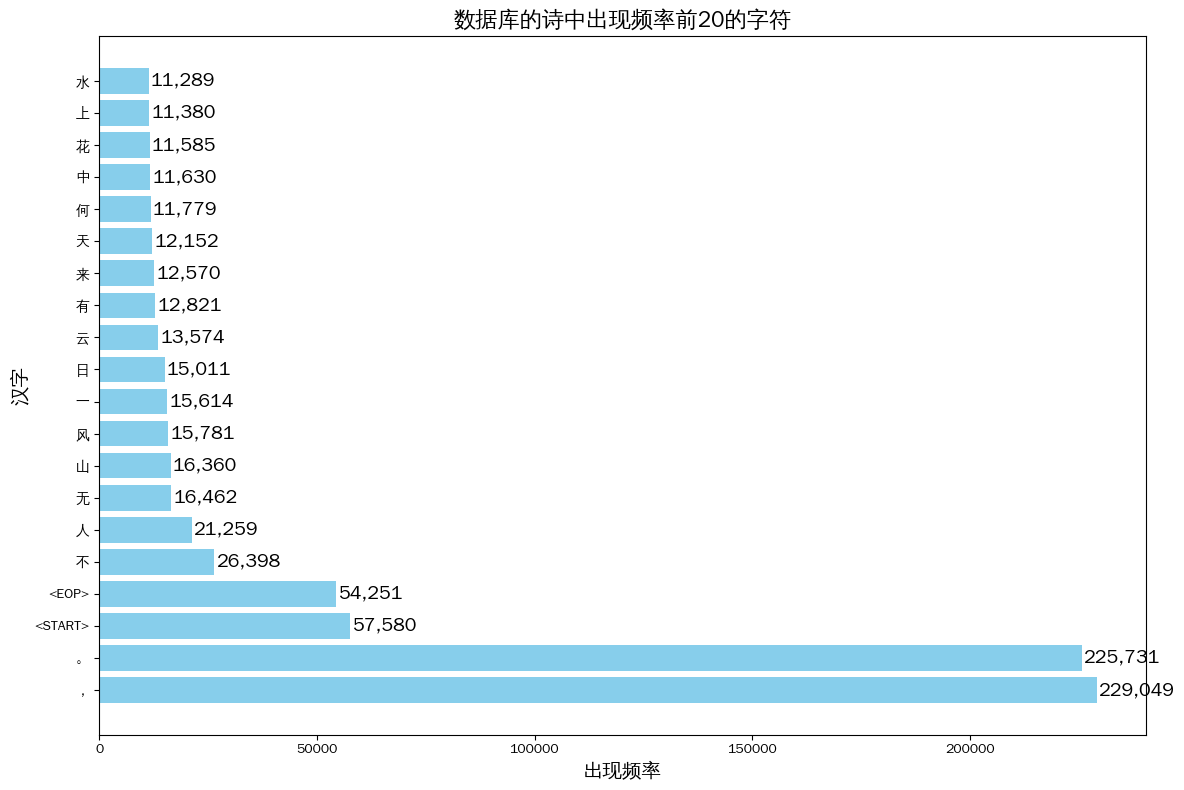

In [11]:
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib as mpl

poems = []
for poemids in data:
    poems.extend(idx2poem(poemids))
count = Counter(poems)

def show_char_distribute(count: Counter):
    # 获取前20个最常出现的字及其频率
    top_chars = count.most_common(20)
    chars = [item[0] for item in top_chars]
    freqs = [item[1] for item in top_chars]

    # 设置中文字体，使中文能正常显示
    plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

    # 创建图形和坐标轴，设置更大的图形尺寸
    fig, ax = plt.subplots(figsize=(12, 8))

    # 创建横向条形图，使字符更容易阅读
    bars = ax.barh(chars, freqs, color='skyblue')

    # 在条形上添加数字标签
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 500, bar.get_y() + bar.get_height()/2, f'{int(width):,}',
                ha='left', va='center', fontsize=14)

    # 添加标题和标签
    ax.set_title('数据库的诗中出现频率前20的字符', fontsize=16)
    ax.set_xlabel('出现频率', fontsize=14)
    ax.set_ylabel('汉字', fontsize=14)

    # 调整布局
    plt.tight_layout()
    plt.show()
show_char_distribute(count)

我发现`<START>`和`<EOP>`出现的次数并不相等，`，`和`。`出现的次数也不相等，后者是正常情况，应为有些诗句会在中间加一个`，`,有的诗句中间是`?`而不是`,`，比如说`此情可待成追忆？只是当时已惘然`。但是前面的`<START>`和`<EOP>`出现的次数不等则可能说明数据集有问题，我需要处理一下。可能的原因如下：

1. **数据采集或预处理错误**：

    部分诗歌可能在末尾缺少 `<EOP>` 标记，或者在开头缺少 `<START>` 标记。此外，某些诗歌内部可能错误地包含了额外的 `<START>` 或 `<EOP>` 标记。最后还有一种原因是在保存或加载数据时，如果发生截断，可能会导致标记丢失。

1.  **特殊格式的诗歌**：

    数据集中可能混入了非标准格式的文本，这些文本没有严格遵循 `<START>...<EOP>` 的模式。

为了解决这个问题，我们可以对数据集进行清洗。主要的思路是：

1.  遍历每一首诗。
2.  检查处理后的诗歌是否同时满足以下条件：
    *   以 `<START>` 标记开头。
    *   以 `<EOP>` 标记结尾。
    *   `<START>` 标记在诗歌中仅出现一次（在开头）。
    *   `<EOP>` 标记在诗歌中仅出现一次（在结尾）。
3.  只保留符合上述条件的诗歌，形成一份清洗后的数据集。

通过这种方式，我可以确保数据集中的每首诗歌都有规范的起止标记，从而提高后续模型训练的质量。

In [12]:
start_token_id = word2ix['<START>']
eop_token_id = word2ix['<EOP>']
pad_token_id = 8292  

cleaned_data = []
original_poem_count = len(data)
i = 0

for poem_indices in data:
    # 移除填充标记
    actual_indices = [idx for idx in poem_indices if idx != pad_token_id]
    
    if not actual_indices: # 如果移除填充后为空，则跳过
        continue
        
    is_valid = True
    # 检查是否以 <START> 开头
    if actual_indices[0] != start_token_id:
        is_valid = False
    
    # 检查是否以 <EOP> 结尾
    if actual_indices[-1] != eop_token_id:
        is_valid = False
        
    # 检查 <START> 和 <EOP> 的数量
    if actual_indices.count(start_token_id) != 1:
        is_valid = False
    if actual_indices.count(eop_token_id) != 1:
        is_valid = False
        
    if is_valid:
        cleaned_data.append(np.array(actual_indices))

cleaned_data = list(cleaned_data)
cleaned_poem_count = len(cleaned_data)

print(f"原始诗歌数量: {original_poem_count}")
print(f"清洗后诗歌数量: {cleaned_poem_count}")
print(f"移除了 {original_poem_count - cleaned_poem_count} 首不规范的诗歌")

原始诗歌数量: 57580
清洗后诗歌数量: 54251
移除了 3329 首不规范的诗歌


In [13]:
cleaned_data[0]

array([8291, 6731, 4770, 1787, 8118, 7577, 7066, 4817,  648, 7121, 1542,
       6483, 7435, 7686, 2889, 1671, 5862, 1949, 7066, 2596, 4785, 3629,
       1379, 2703, 7435, 6064, 6041, 4666, 4038, 4881, 7066, 4747, 1534,
         70, 3788, 3823, 7435, 4907, 5567,  201, 2834, 1519, 7066,  782,
        782, 2063, 2031,  846, 7435, 8290], dtype=int32)

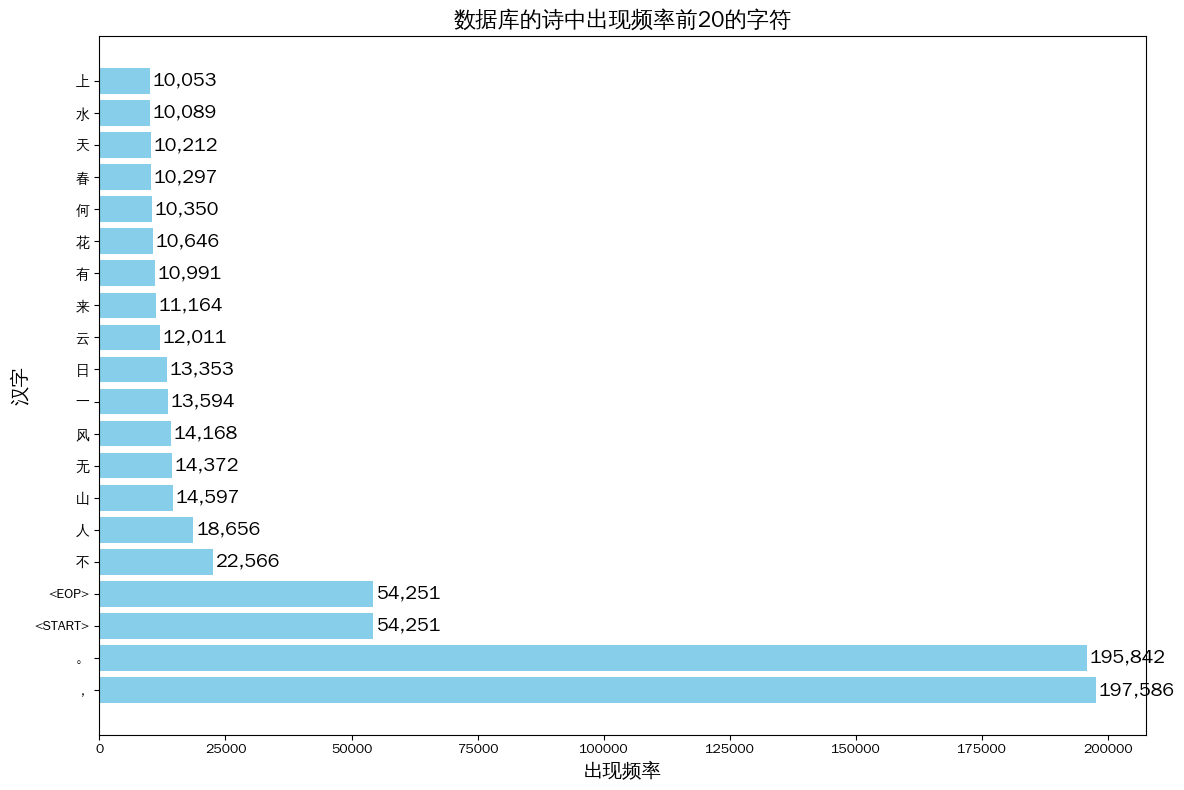

['<START>',
 '度',
 '门',
 '能',
 '不',
 '访',
 '，',
 '冒',
 '雪',
 '屡',
 '西',
 '东',
 '。',
 '已',
 '想',
 '人',
 '如',
 '玉',
 '，',
 '遥',
 '怜',
 '马',
 '似',
 '骢',
 '。',
 '乍',
 '迷',
 '金',
 '谷',
 '路',
 '，',
 '稍',
 '变',
 '上',
 '阳',
 '宫',
 '。',
 '还',
 '比',
 '相',
 '思',
 '意',
 '，',
 '纷',
 '纷',
 '正',
 '满',
 '空',
 '。',
 '<EOP>']

In [14]:
total_chars = []
poems = []
for poemids in cleaned_data:
    total_chars.extend(idx2poem(poemids))
    poems.append(idx2poem(poemids))
count = Counter(total_chars)

show_char_distribute(count)
poems[0]

In [15]:
poems = [''.join(poem) for poem in poems]
poems[0]

'<START>度门能不访，冒雪屡西东。已想人如玉，遥怜马似骢。乍迷金谷路，稍变上阳宫。还比相思意，纷纷正满空。<EOP>'



## 构造dataset

In [16]:
class PoemDataset(torch.utils.data.Dataset):
    def __init__(self, data) -> None:
        super().__init__()
        self.data = data # 为一个数组，数组里面的元素是一首诗的各个字符串

    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, index) -> tuple[str, str]:
        '''从数据集中获取数据，第一个数据prompt是输入给模型的提示词（一首诗的前两句），第二个poem是整首诗'''
        poem: str = self.data[index]
        prompt_index = poem.index('。')
        prompt = poem[:prompt_index+1]
        return prompt, poem

In [17]:
total_dataset = PoemDataset(poems)

In [20]:
total_dataset[0]
np.save(CLEAR_DATA_FILE, poems)